In [1]:
import pandas as pd
import numpy as np
import cPickle as pickle
import datetime

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
df = pd.read_pickle('df_1to10999_geo_cleaned.pkl')

Use INITdT_dt, days to repair, and total initialized on a day to keep a running cumulative total of all the potholes unrepaired in the system on the day each potholes is initiated.  So each row should have a cumulative total associated with its INITDT_dt.

In [4]:
df['INITDT_date_only'] = df['INITDT_dt'].apply( lambda x: x.date())
df['INITDT_date_only'] = pd.to_datetime(df.INITDT_date_only)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6996 entries, 0 to 10999
Data columns (total 13 columns):
OBJECTID            6996 non-null int64
WOKEY               6996 non-null int64
LOCATION            6996 non-null object
ADDRDESC            6996 non-null object
INITDT_dt           6996 non-null datetime64[ns]
FLDSTARTDT_dt       6996 non-null datetime64[ns]
FLDENDDT_dt         6996 non-null datetime64[ns]
DURATION            6996 non-null timedelta64[ns]
DURATION_td         6996 non-null float64
latitude            6996 non-null float64
longitude           6996 non-null float64
address             6996 non-null object
INITDT_date_only    6996 non-null datetime64[ns]
dtypes: datetime64[ns](4), float64(3), int64(2), object(3), timedelta64[ns](1)
memory usage: 765.2+ KB


In [6]:
df.head(2)

,OBJECTID,WOKEY,LOCATION,ADDRDESC,INITDT_dt,FLDSTARTDT_dt,FLDENDDT_dt,DURATION,DURATION_td,latitude,longitude,address,INITDT_date_only
0,1,2456,Holden pl SW bt SW Kenyon Holden ...,HOLDEN PL SW BETWEEN SW HOLDEN ST AND SW KENYO...,2010-03-29 07:00:00,2010-04-06 07:00:00,2010-04-06 07:00:00,8 days,8,47.531858,-122.363186,"SW Kenyon St, Seattle, WA, USA",2010-03-29
1,2,2514,"NE Pacific Street, one block west of Montlake ...",MONTLAKE BLVD NE AND NE PACIFIC ST ...,2010-03-30 07:00:00,2010-04-01 07:00:00,2010-04-01 07:00:00,2 days,2,47.649014,-122.304655,"Montlake Blvd NE & NE Pacific St, Seattle, WA ...",2010-03-30


Easy: Just groupby on dates, ultimately you want the total that are live on each date.  this table could then be joined to the main dataframe to get the total live on the day each pothole was initiated.  Loop through each row: For a given row associated with a given day, the live potholes will be: 1).  All those intiated on that day, + 2). all the other potholes for which their initiation day + duration is greater than that day.

In [7]:
df_number_potholes = pd.DataFrame(df.groupby('INITDT_date_only')['OBJECTID'].count()).reset_index()

In [8]:
df_number_potholes.rename(columns={'OBJECTID': 'Number_potholes'}, inplace=True)

In [24]:
df_number_potholes.head(10)

,INITDT_date_only,Number_potholes
0,2010-03-11,1
1,2010-03-15,3
2,2010-03-16,5
3,2010-03-19,1
4,2010-03-22,5
5,2010-03-24,9
6,2010-03-26,4
7,2010-03-27,2
8,2010-03-28,1
9,2010-03-29,3


In [33]:
df_number_potholes.tail()

,INITDT_date_only,Number_potholes
1588,2015-08-20,3
1589,2015-08-21,3
1590,2015-08-22,2
1591,2015-08-23,1
1592,2015-08-24,1


In [10]:
df_number_potholes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1593 entries, 0 to 1592
Data columns (total 2 columns):
INITDT_date_only    1593 non-null datetime64[ns]
Number_potholes     1593 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 37.3 KB


In [11]:
df.ix[0, 'INITDT_date_only'], df.ix[0, 'DURATION'], df_number_potholes.ix[0, 'INITDT_date_only']

(Timestamp('2010-03-29 00:00:00'),
 Timedelta('8 days 00:00:00'),
 Timestamp('2010-03-11 00:00:00'))

In [12]:
df.ix[0, 'INITDT_date_only'] + df.ix[0, 'DURATION'] > df_number_potholes.ix[0, 'INITDT_date_only']

True

In [13]:
(df.ix[0, 'INITDT_date_only'] + df.ix[0, 'DURATION'] > df_number_potholes.ix[0, 'INITDT_date_only']) \
and (df_number_potholes.ix[0, 'INITDT_date_only'] > df.ix[0, 'INITDT_date_only']) 

False

In [34]:
cum_potholes = []
# for date_item in df_number_potholes.index.tolist():
for date_item in xrange(1593):
    total = 0
    for each_item in df.index.tolist():
        if (df.ix[each_item, 'INITDT_date_only'] + df.ix[each_item, 'DURATION'] > df_number_potholes.ix[date_item, 'INITDT_date_only'])\
        and (df_number_potholes.ix[date_item, 'INITDT_date_only'] >= df.ix[each_item, 'INITDT_date_only']):
            total += 1
    cum_potholes.append(total)
print cum_potholes

[1, 4, 6, 1, 6, 9, 7, 9, 10, 8, 8, 5, 5, 3, 4, 4, 5, 4, 8, 2, 1, 1, 3, 13, 11, 15, 15, 9, 8, 8, 8, 7, 9, 7, 10, 8, 3, 4, 5, 6, 6, 7, 3, 3, 2, 2, 3, 7, 8, 7, 10, 11, 12, 11, 11, 13, 14, 17, 15, 13, 10, 10, 10, 8, 8, 7, 5, 8, 9, 7, 8, 4, 4, 2, 4, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 1, 4, 2, 1, 2, 2, 2, 3, 4, 4, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 3, 4, 4, 4, 5, 2, 3, 3, 5, 7, 10, 9, 7, 10, 11, 12, 8, 8, 8, 7, 4, 5, 1, 4, 5, 6, 9, 8, 8, 10, 13, 10, 11, 13, 14, 15, 18, 19, 19, 14, 14, 12, 13, 14, 15, 14, 14, 21, 23, 25, 31, 32, 33, 32, 39, 44, 55, 54, 57, 63, 92, 102, 126, 144, 145, 147, 152, 164, 189, 198, 215, 219, 221, 222, 228, 230, 225, 235, 237, 243, 249, 285, 269, 271, 275, 275, 277, 280, 275, 264, 308, 346, 332, 332, 336, 345, 351, 355, 331, 311, 312, 319, 290, 289, 267, 255, 248, 247, 253, 240, 221, 231, 248, 226, 228, 230, 235, 232, 225, 225, 211, 212, 216, 190, 168, 159, 160, 149, 151, 152, 154, 131, 132, 136, 118, 119, 124, 106, 102, 95, 84, 75, 78, 80, 79, 70, 57, 

####The first 50: [1, 4, 6, 1, 6, 9, 7, 9, 10, 8, 8, 5, 5, 3, 4, 4, 5, 4, 8, 2, 1, 1, 3, 13, 11, 15, 15, 9, 8, 8, 8, 7, 9, 7, 10, 8, 3, 4, 5, 6, 6, 7, 3, 3, 2, 2, 3, 7, 8, 7]

At 6.5 min per 50, it should take about 3.5 hrs to do the whole run.  Why didn't it finish last night?

In [35]:
len(cum_potholes)

1593

In [36]:
df_number_potholes['cumul_potholes'] = cum_potholes

In [37]:
df_number_potholes.head(5)

,INITDT_date_only,Number_potholes,cumul_potholes
0,2010-03-11,1,1
1,2010-03-15,3,4
2,2010-03-16,5,6
3,2010-03-19,1,1
4,2010-03-22,5,6


In [38]:
df_number_potholes.tail()

,INITDT_date_only,Number_potholes,cumul_potholes
1588,2015-08-20,3,3
1589,2015-08-21,3,5
1590,2015-08-22,2,7
1591,2015-08-23,1,7
1592,2015-08-24,1,3


In [39]:
df_number_potholes.to_pickle('df_number_potholes.pkl')

In [40]:
df = df.reset_index()
df = pd.merge(df, df_number_potholes, how='left', on='INITDT_date_only')
df = df.set_index('index')


In [41]:
df.head(2)

,OBJECTID,WOKEY,LOCATION,ADDRDESC,INITDT_dt,FLDSTARTDT_dt,FLDENDDT_dt,DURATION,DURATION_td,latitude,longitude,address,INITDT_date_only,Number_potholes,cumul_potholes
index,,,,,,,,,,,,,,,
0,1,2456,Holden pl SW bt SW Kenyon Holden ...,HOLDEN PL SW BETWEEN SW HOLDEN ST AND SW KENYO...,2010-03-29 07:00:00,2010-04-06 07:00:00,2010-04-06 07:00:00,8 days,8,47.531858,-122.363186,"SW Kenyon St, Seattle, WA, USA",2010-03-29,3,8
1,2,2514,"NE Pacific Street, one block west of Montlake ...",MONTLAKE BLVD NE AND NE PACIFIC ST ...,2010-03-30 07:00:00,2010-04-01 07:00:00,2010-04-01 07:00:00,2 days,2,47.649014,-122.304655,"Montlake Blvd NE & NE Pacific St, Seattle, WA ...",2010-03-30,2,8


In [42]:
df.tail(2)

,OBJECTID,WOKEY,LOCATION,ADDRDESC,INITDT_dt,FLDSTARTDT_dt,FLDENDDT_dt,DURATION,DURATION_td,latitude,longitude,address,INITDT_date_only,Number_potholes,cumul_potholes
index,,,,,,,,,,,,,,,
10998,10999,96785,9719 3rd Ave NW ...,3RD AVE NW BETWEEN NW 97TH ST AND NW 100TH ST ...,2011-12-28 08:00:00,2011-12-30 08:00:00,2011-12-30 08:00:00,2 days,2,47.701542,-122.374093,"NW 100th St, Seattle, WA 98177, USA",2011-12-28,1,2
10999,11000,107829,Rainier Ave S to S Massachusetts ...,RAINIER AVE S BETWEEN RAINIER NB (I90 EB ON RP...,2012-03-19 07:00:00,2012-03-20 07:00:00,2012-03-20 07:00:00,1 days,1,47.588483,-122.313814,"S Massachusetts St, Seattle, WA, USA",2012-03-19,16,26


####Produce time series plots of cumul potholes before I go any further.  Move the code to the mapping py file.

In [43]:
df_number_potholes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1593 entries, 0 to 1592
Data columns (total 3 columns):
INITDT_date_only    1593 non-null datetime64[ns]
Number_potholes     1593 non-null int64
cumul_potholes      1593 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 49.8 KB


In [44]:
import matplotlib.pyplot as plt

In [66]:
import matplotlib
matplotlib.style.use('ggplot')

In [45]:
%matplotlib inline

In [57]:
df_number_potholes = df_number_potholes.set_index('INITDT_date_only')

In [79]:
df_number_potholes.index.name=''

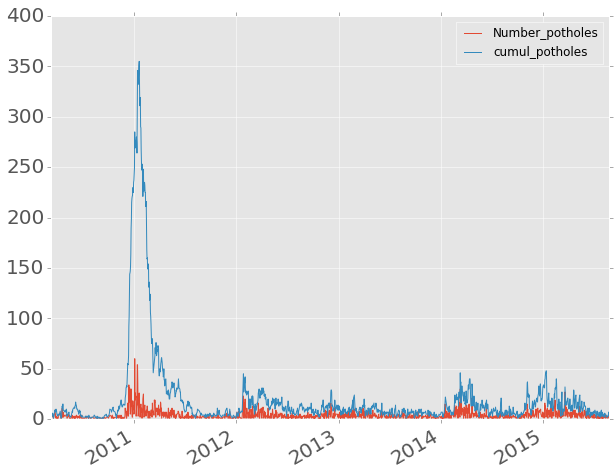

In [83]:
ax = fig.add_subplot(111)
df_number_potholes.plot(figsize=(10,8),fontsize=20)
plt.savefig('Number_of_Potholes.png')

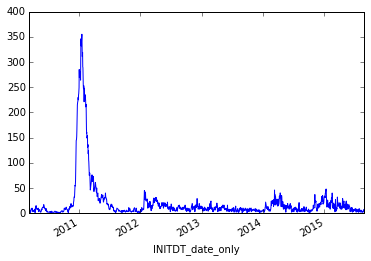

In [60]:
df_number_potholes['cumul_potholes'].plot()

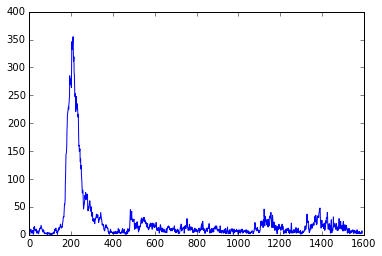

In [51]:
plt.plot(df_number_potholes.index, df_number_potholes['cumul_potholes'])

In [ ]:
df_number_potholes['cumul_potholes']

In [61]:
ts = pd.Series(df_number_potholes['cumul_potholes'], index=df_number_potholes.index)

In [62]:
ts

INITDT_date_only
2010-03-11     1
2010-03-15     4
2010-03-16     6
2010-03-19     1
2010-03-22     6
2010-03-24     9
2010-03-26     7
2010-03-27     9
2010-03-28    10
2010-03-29     8
2010-03-30     8
2010-03-31     5
2010-04-01     5
2010-04-02     3
2010-04-04     4
2010-04-05     4
2010-04-06     5
2010-04-08     4
2010-04-12     8
2010-04-14     2
2010-04-15     1
2010-04-16     1
2010-04-17     3
2010-04-19    13
2010-04-20    11
2010-04-21    15
2010-04-22    15
2010-04-23     9
2010-04-26     8
2010-04-27     8
              ..
2015-07-21     3
2015-07-22     4
2015-07-23     2
2015-07-24     7
2015-07-27     9
2015-07-28     3
2015-07-29     7
2015-07-30     3
2015-07-31     6
2015-08-01     5
2015-08-02     5
2015-08-03     4
2015-08-04     3
2015-08-05     4
2015-08-06     2
2015-08-07     6
2015-08-10     5
2015-08-11     5
2015-08-12     4
2015-08-13     2
2015-08-14     3
2015-08-16     3
2015-08-17     2
2015-08-18     3
2015-08-19     3
2015-08-20     3
2015-08-21    

TypeError: There is no line property "name"

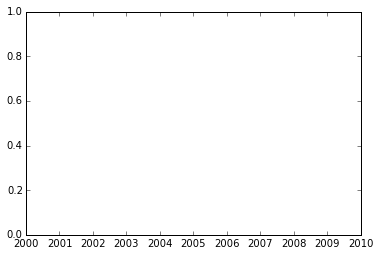

In [64]:
ts.plot(name=False)